<a href="https://colab.research.google.com/github/nghess/607-sensory-coding/blob/main/3dCNN_v1_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import os

# Replace 'YourFolder' with the path where you want to clone the repo
path = "/content/drive/My Drive/607_sensory_coding"
os.chdir(path)

# Replace 'YourGitRepoURL' with the URL of the Git repository
!git clone https://github.com/nghess/607-sensory-coding

fatal: destination path '607-sensory-coding' already exists and is not an empty directory.


In [7]:
# Navigate to the repository's directory
repo_path = os.path.join(path, '607-sensory-coding')
os.chdir(repo_path)

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import tifffile as tiff
import pandas as pd
import numpy as np
import os

In [9]:
class TiffDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_name = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = tiff.imread(img_name)  # Load stack

        if self.transform:
            image = self.transform(image)

        # Ensure the image is a float tensor
        if not isinstance(image, torch.FloatTensor):
            image = image.type(torch.FloatTensor)

        # Convert labels to numerical format
        rotation_class = 1 if self.annotations.iloc[index, 1] == 'clockwise' else 0
        input_class_mapping = {'cross': 0, 'tee': 1, 'elbow': 2, 'radius': 3, 'diameter': 4}
        input_class = input_class_mapping[self.annotations.iloc[index, 2]]

        # Combine the labels (e.g., using one-hot encoding for the input class)
        label = torch.tensor([rotation_class, input_class], dtype=torch.long)

        return image, label

# Run transforms. Normalizes image stacks between 0 and 1.
transform = transforms.Compose([
    transforms.ToTensor(),
])

dataset = TiffDataset(csv_file='dataset/labels.csv', root_dir='dataset/', transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

## Define Model

In [10]:
class Simple3DCNN(nn.Module):
    def __init__(self):
        super(Simple3DCNN, self).__init__()
        self.conv1 = nn.Conv3d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv3d(16, 32, 3, padding=1)
        self.fc1 = nn.Linear(32 * 32 * 45 * 32, 512)  # Adjust the size
        self.fc_rotation = nn.Linear(512, 2)  # Two classes for rotation
        self.fc_input = nn.Linear(512, 5)  # Five classes for input type

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        #print(x.shape) #torch.Size([32, 64, 45, 64]) for 256x256 [32, 32, 45, 32]) for 128x128
        x = x.view(-1, 32 * 32 * 45 * 32)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        rotation_output = self.fc_rotation(x)
        input_output = self.fc_input(x)
        return rotation_output, input_output

model = Simple3DCNN()

## Train Model

In [ ]:
epochs = 100

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# Initialize a list to keep track of loss values
loss_values = []

# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is active.")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the device (GPU or CPU)
model = model.to(device)

for epoch in range(epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(dataloader):

        # Move to GPU
        inputs, labels = inputs.to(device), labels.to(device)

        # Split the labels
        rotation_labels = labels[:, 0]
        input_labels = labels[:, 1]

        # Reset gradient
        optimizer.zero_grad()
        outputs = model(inputs)

        # Assuming your model's output is designed to handle both types of labels
        loss_rotation = criterion(outputs[0], rotation_labels)
        loss_input = criterion(outputs[1], input_labels)
        loss = loss_rotation + loss_input  # Combine losses, or handle as you see fit

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # At the end of each epoch, store the average loss
    epoch_loss = running_loss / len(dataloader)
    loss_values.append(epoch_loss)
    print(f'Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss:.4f}')

### Save Model to File

In [14]:
torch.save(model, '/content/drive/My Drive/607_sensory_coding/test_model.pt')

In [25]:
print(model)

Simple3DCNN(
  (conv1): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (pool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (fc1): Linear(in_features=1474560, out_features=512, bias=True)
  (fc_rotation): Linear(in_features=512, out_features=2, bias=True)
  (fc_input): Linear(in_features=512, out_features=5, bias=True)
)


## Test Model

In [18]:
test_dataset = TiffDataset(csv_file='dataset/labels.csv', root_dir='dataset/', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [24]:
def get_sample_input(data_loader):
    """
    Get a single sample input from the data loader.

    :param data_loader: DataLoader for your dataset.
    :return: A single sample input tensor.
    """
    # Iterate over the data_loader to get a single batch
    for inputs, _ in data_loader:
        # Select the first instance in the batch
        sample_input = inputs[0]
        return sample_input

# Example usage
# Assuming you have a DataLoader for your test dataset named `test_loader`
sample_input = get_sample_input(test_loader)

# Now you can use this `sample_input` with the feature map visualization function


torch.Size([128, 180, 128])


In [11]:
def test_model(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    correct_rotation, correct_input, total = 0, 0, 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            rotation_labels, input_labels = labels[:, 0], labels[:, 1]

            rotation_output, input_output = model(inputs)

            _, predicted_rotation = torch.max(rotation_output.data, 1)
            _, predicted_input = torch.max(input_output.data, 1)

            total += labels.size(0)
            correct_rotation += (predicted_rotation == rotation_labels).sum().item()
            correct_input += (predicted_input == input_labels).sum().item()

    print(f'Accuracy of the network on rotation prediction: {100 * correct_rotation / total}%')
    print(f'Accuracy of the network on input type prediction: {100 * correct_input / total}%')

test_model(model, test_loader, device)


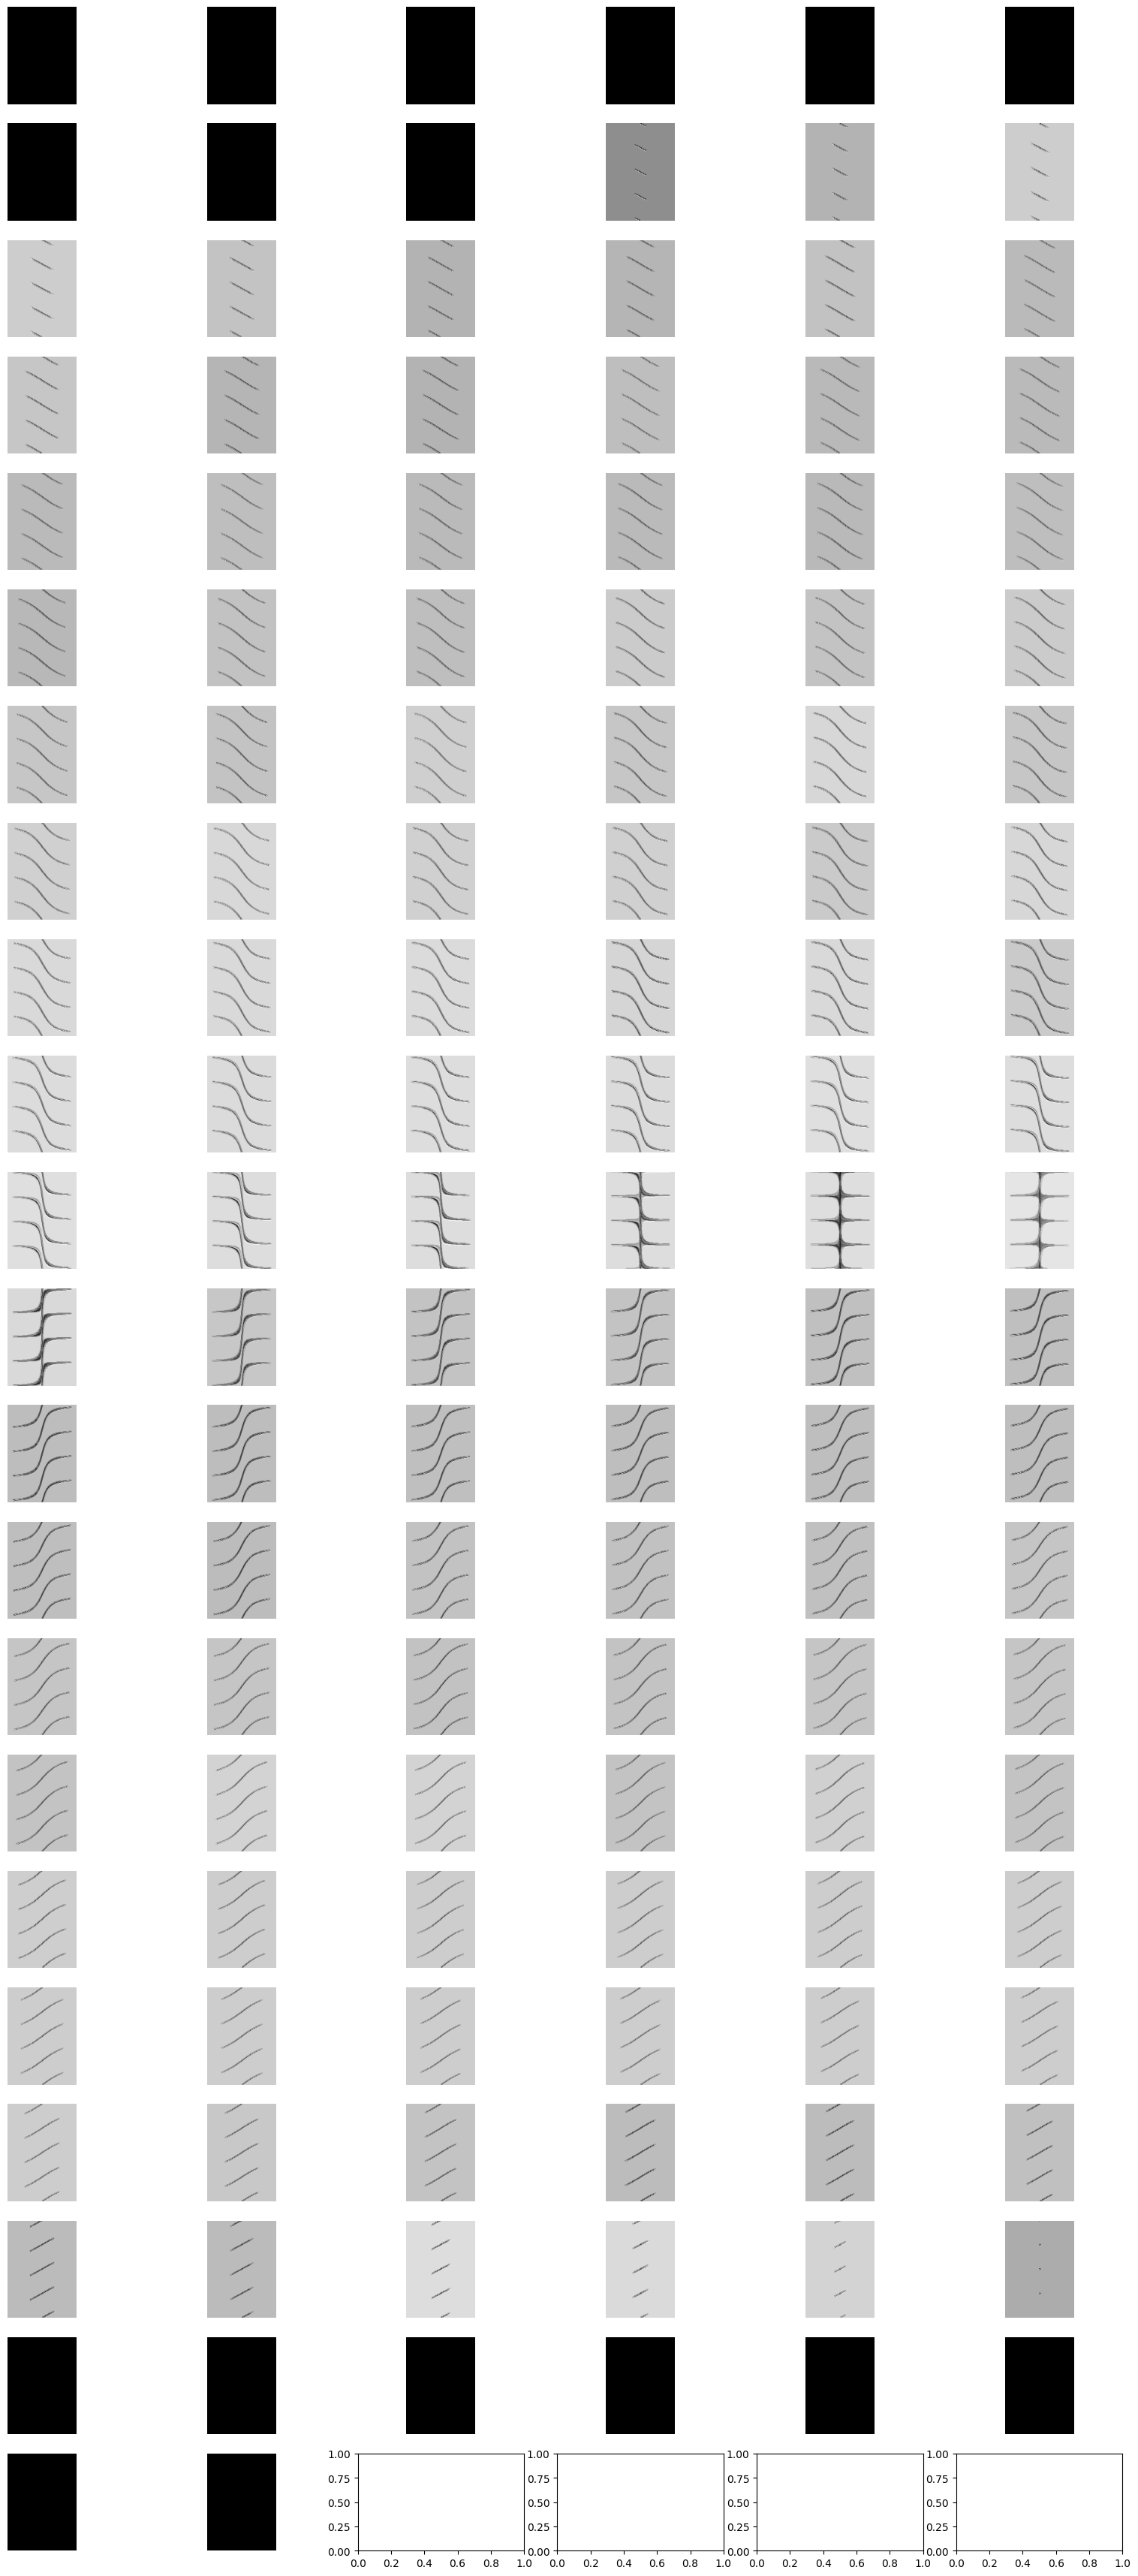

In [31]:
def plot_feature_maps(model, input_tensor, selected_layers, ncols=6):
    """
    Plot feature maps for selected layers of the model.

    :param model: The trained 3D CNN model.
    :param input_tensor: A single input tensor from the test set.
    :param selected_layers: List of layer names to visualize.
    :param ncols: Number of columns in the plot grid.
    """
    model.eval()

    # A function to get the output of a layer
    def get_features_map(layer, input, output):
        feature_maps.append(output.cpu().data.numpy())

    # Attach hooks to the selected layers
    hooks = []
    for name, layer in model.named_modules():
        if name in selected_layers:
            hooks.append(layer.register_forward_hook(get_features_map))

    # Initialize the feature maps list and pass the input through the model
    feature_maps = []
    with torch.no_grad():
        model(input_tensor.unsqueeze(0).to(device))

    # Remove hooks (important to avoid memory leak)
    for hook in hooks:
        hook.remove()

    # Plotting
    for layer_maps in feature_maps:
        n_features = layer_maps.shape[1]
        nrows = n_features // ncols + int(n_features % ncols != 0)
        fig, axes = plt.subplots(nrows, ncols, figsize=(20, 2 * nrows))
        for i in range(n_features):
            row = i // ncols
            col = i % ncols
            ax = axes[row, col] if nrows > 1 else axes[col]
            ax.imshow(layer_maps[0, i, :, :], cmap='gray')
            ax.axis('off')
        plt.show()

# Pull out a layer and plot slices
selected_layers = ['conv1']
plot_feature_maps(model, sample_input, selected_layers, ncols=6)
